In [1]:

import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.custom_dm as cdm

from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm
det_rotation = -7.5 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
# dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)


# Full model acting as testbed

Model using synthetic OPD data


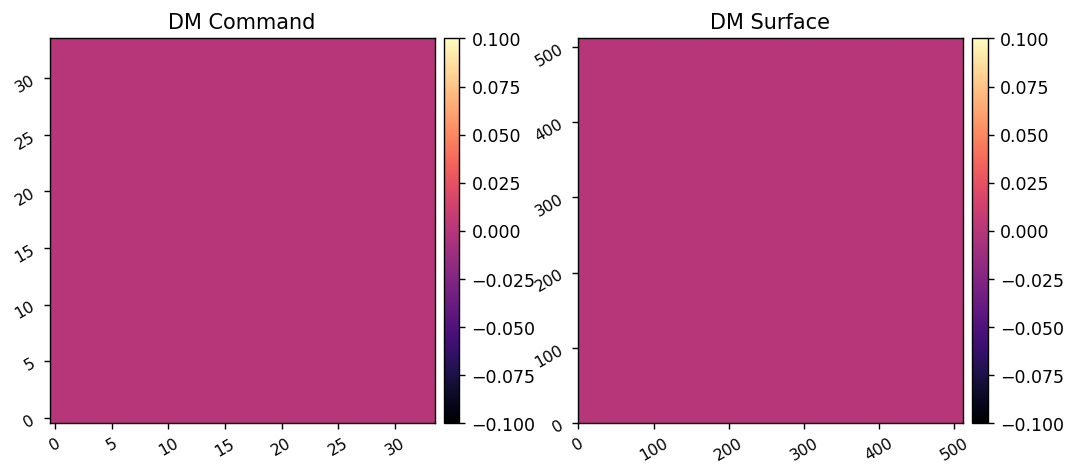

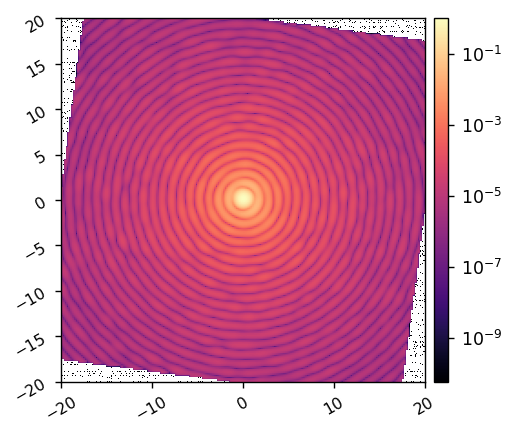

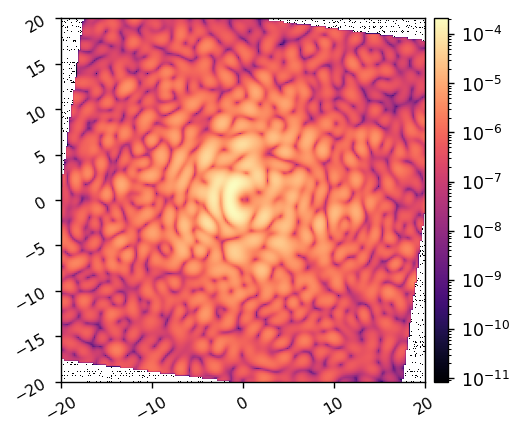

In [26]:
reload(scoobpsf.scoob)
full = scoobpsf.scoob.SCOOBM(npix=npix, 
                      oversample=oversample, 
                     npsf=200,
                      wavelength=wavelength_c, 
                      pupil_diam=pupil_diam,
                      det_rotation=det_rotation, 
                      use_synthetic_opds=True,
#                       dm_ref=dm_flat,
                     )

full.show_dm()

im0 = full.snap()
full.Imax_ref = im0.max()

ref_unocc_im = full.snap(plot=True)

full.FPM = vortex
full.LYOT = lyot_stop

full_ref_im = full.snap(plot=True)

# Compact model for HOWFSC

In [4]:
reload(cscoob)
reload(cdm)
model = cscoob.SCOOB(npix=200, oversample=10, npsf=200, dm_fill_factor=0.94)


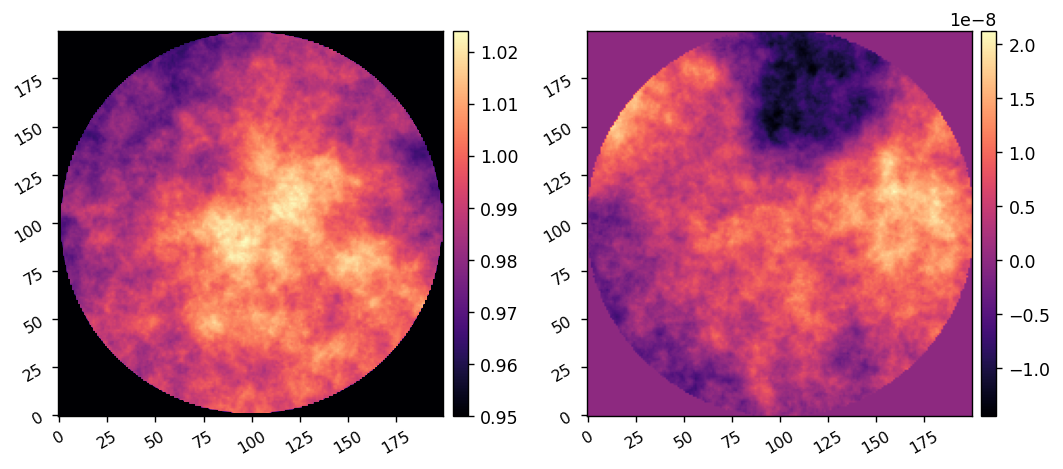

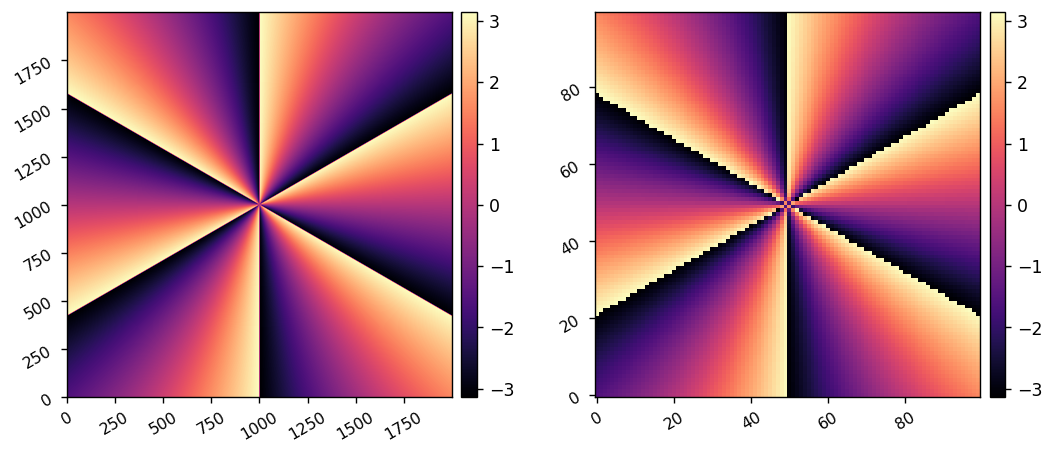

In [5]:
reload(cscoob)
WFE = cscoob.generate_wfe(diam=model.pupil_diam, distance=50*u.mm, 
                          amp_rms=0.025*u.nm, amp_index=3, amp_seed=1234,
                          opd_rms=10*u.nm, opd_index=3, opd_seed=2345,
                          npix=model.npix, oversample=model.oversample,)
model.WFE = WFE
imshow2(xp.abs(WFE), xp.angle(WFE)/(2*np.pi)*model.wavelength.to_value(u.m), 
        npix=model.npix,
        vmin1=0.95)

VC = cscoob.make_vortex_phase_mask(model.focal_grid_pol, charge=6, 
#                                    singularity=20*u.um, 
                                   focal_length=500*u.mm, pupil_diam=9.7*u.mm, wavelength=632.8*u.nm)
imshow2(xp.angle(VC), xp.angle(scoobpsf.utils.pad_or_crop(VC, 100)))
model.FPM = VC

LS = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
model.LYOT = LS

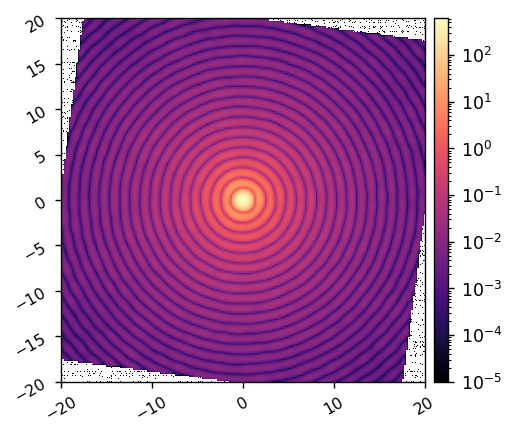

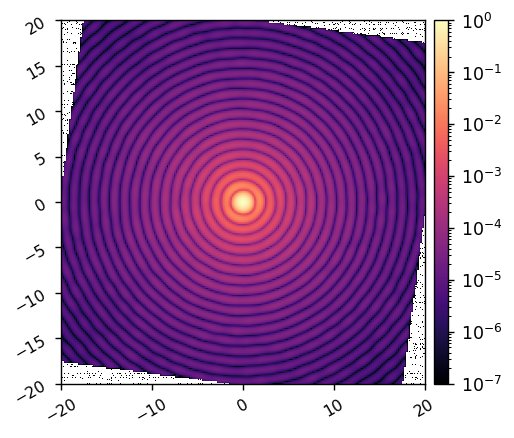

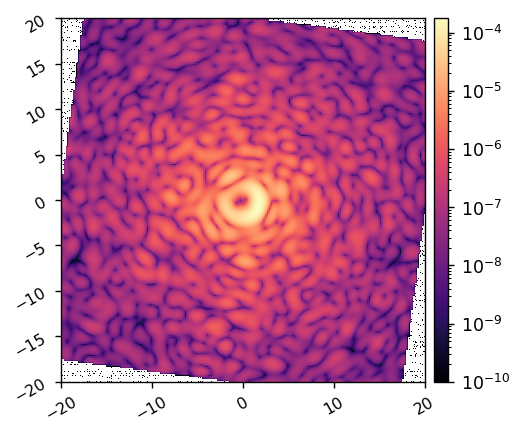

In [10]:
model.det_rotation = -7.5
model.npsf = 200
model.FPM = None

model.Imax_ref = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)

model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

model.FPM = VC
ref_im = model.snap(plot=True, vmin=1e-10)

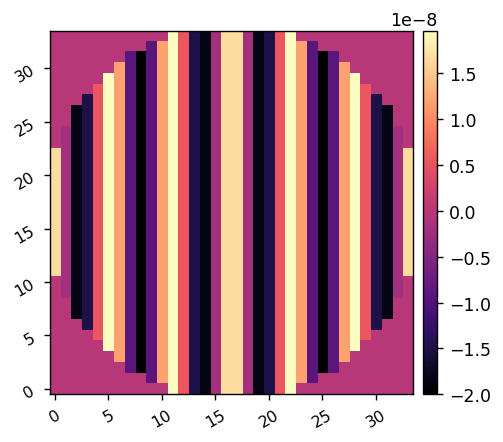

In [11]:
xpp = np.linspace(-full.Nact/2, full.Nact/2-1, full.Nact) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

amp = 2e-8

x_sep = 6
y_sep = 0
command = amp*np.cos(2*np.pi*ppx*x_sep/full.Nact + 2*np.pi*ppy*y_sep/full.Nact)*full.dm_mask
imshow1(command)

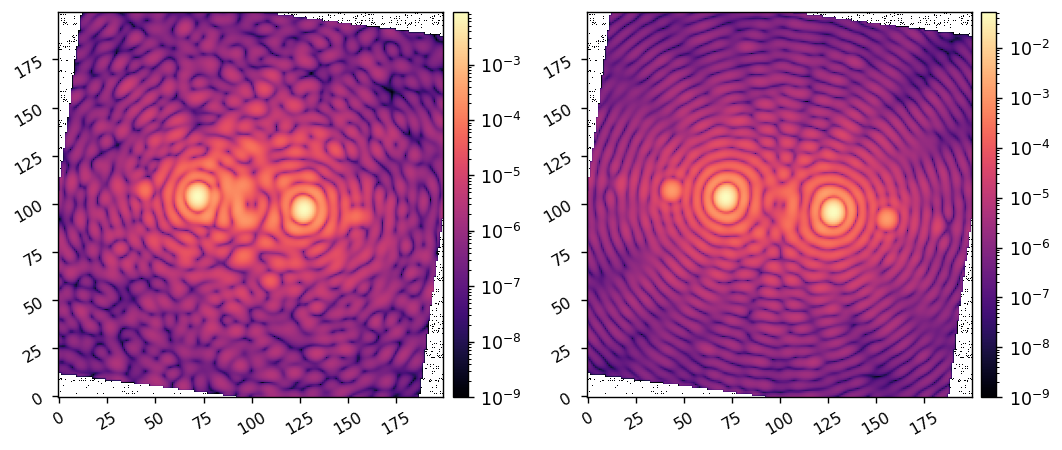

In [12]:
full.add_dm(command)
model.add_dm(command)

image = full.snap()
model_im = model.snap()

full.reset_dm()
model.reset_dm()

imshow2(image, model_im, lognorm=True, vmin1=1e-9, vmin2=1e-9)

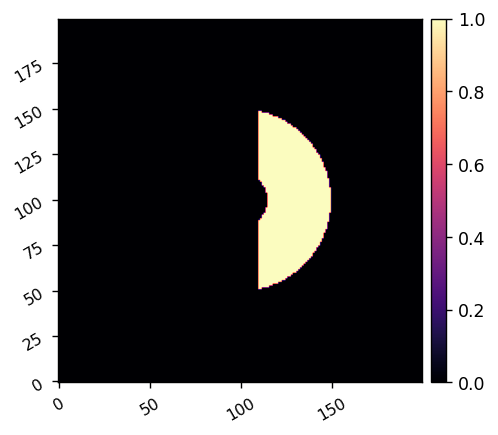

In [13]:
control_mask = (model.im_grid_pol[0] > 3)*(model.im_grid_pol[0] < 10)*(model.im_grid_car[0]>2)
imshow1(ensure_np_array(control_mask))

In [17]:
model.bad_acts = None

In [15]:
import lina

In [18]:
reload(lina.efc)
jac = lina.efc.build_jacobian(model, 1e-9, control_mask,)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=17.984 sec.
Jacobian built in 17.984 sec


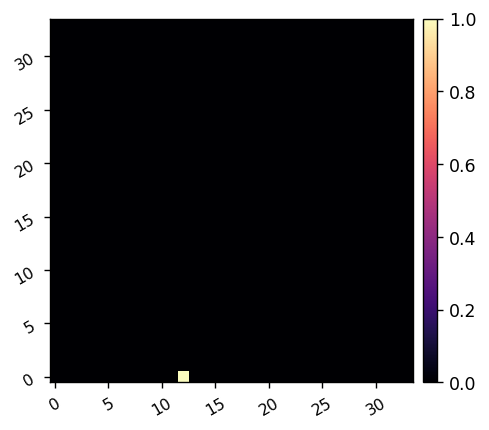

In [46]:
calib_amp = 1e-9
calib_modes = lina.utils.create_all_poke_modes(model.dm_mask)
imshow1(calib_modes[1].reshape(model.Nact, model.Nact))

In [63]:
model.reset_dm()

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=17.998 sec.
Jacobian built in 17.998 sec


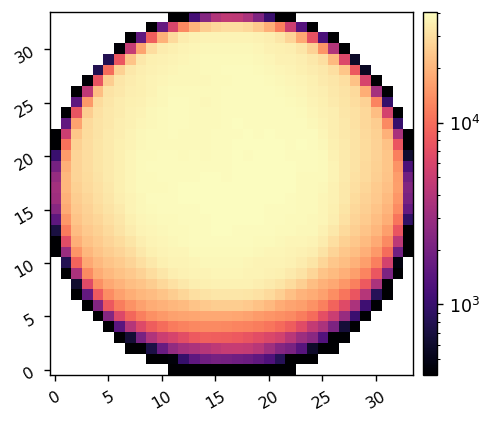

In [66]:
reload(lina.efc)
jac = lina.efc.build_jacobian(model, calib_modes, calib_amp, control_mask, plot=True)

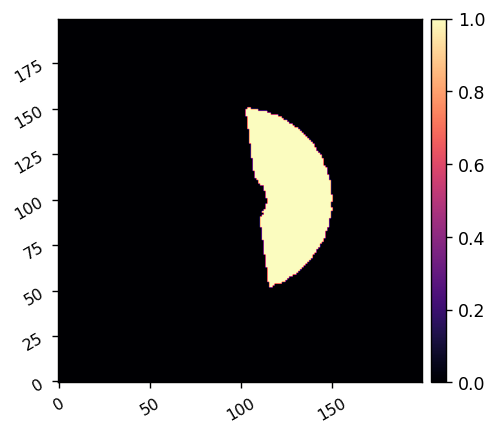

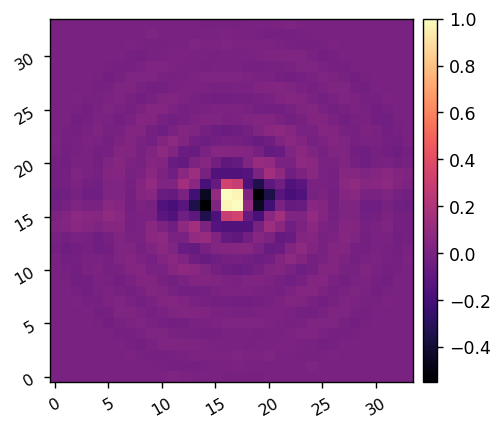

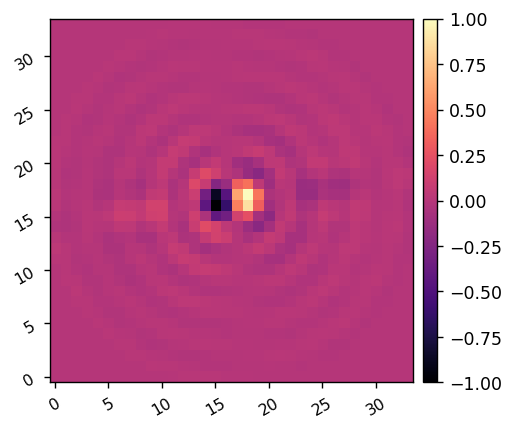

In [67]:
control_mask_for_probes = _scipy.ndimage.rotate(control_mask, angle=model.det_rotation, reshape=False, order=1)
imshow1(control_mask_for_probes)

probe_amp = 1e-8
probe_modes = lina.utils.create_fourier_probes(model, control_mask_for_probes, plot=True)
probes = probe_amp*probe_modes

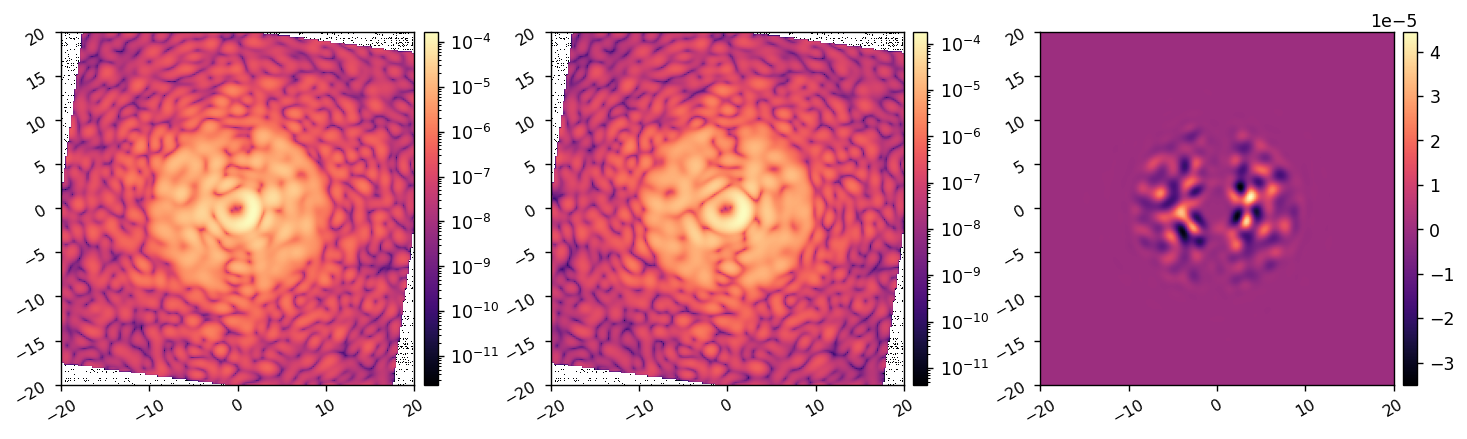

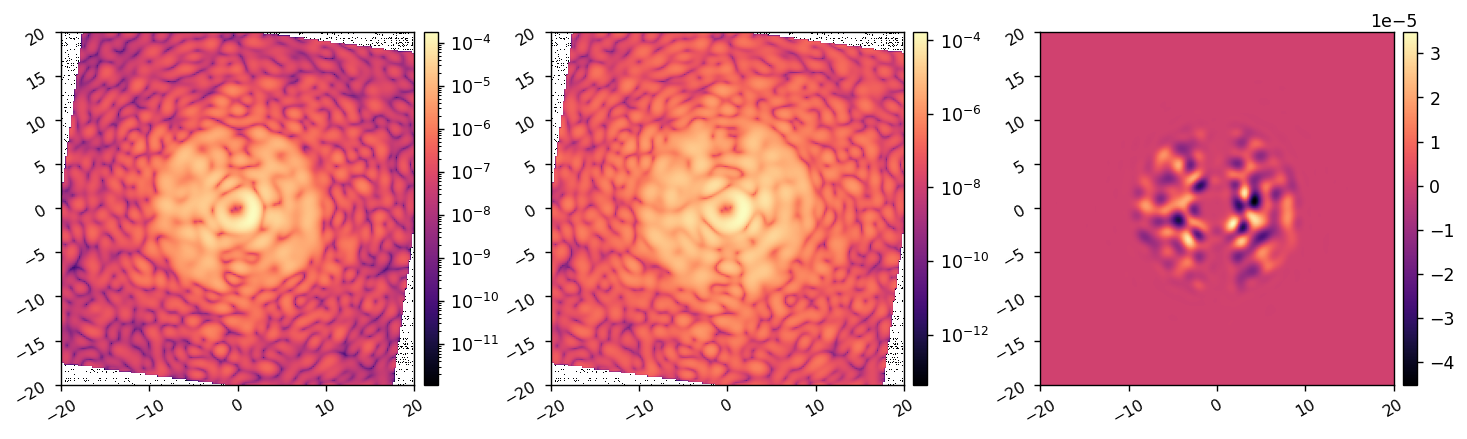

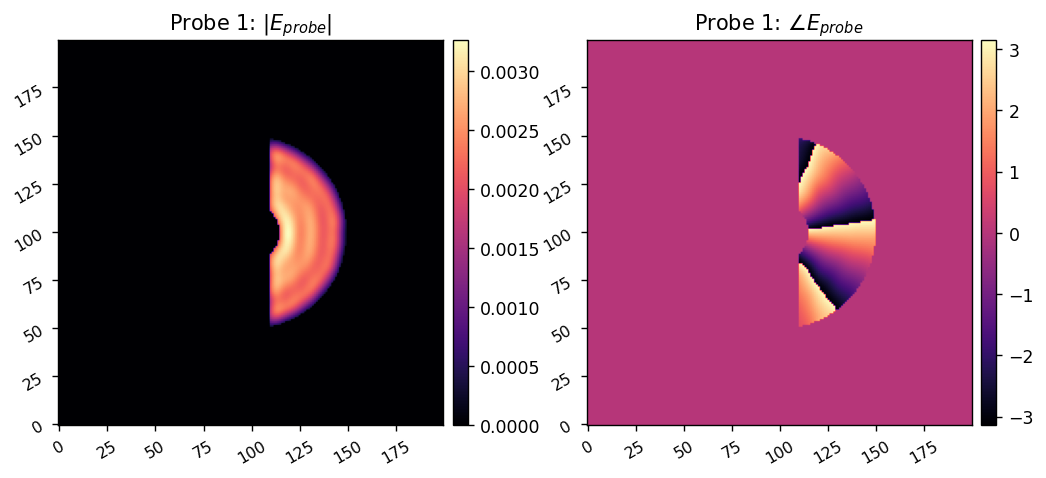

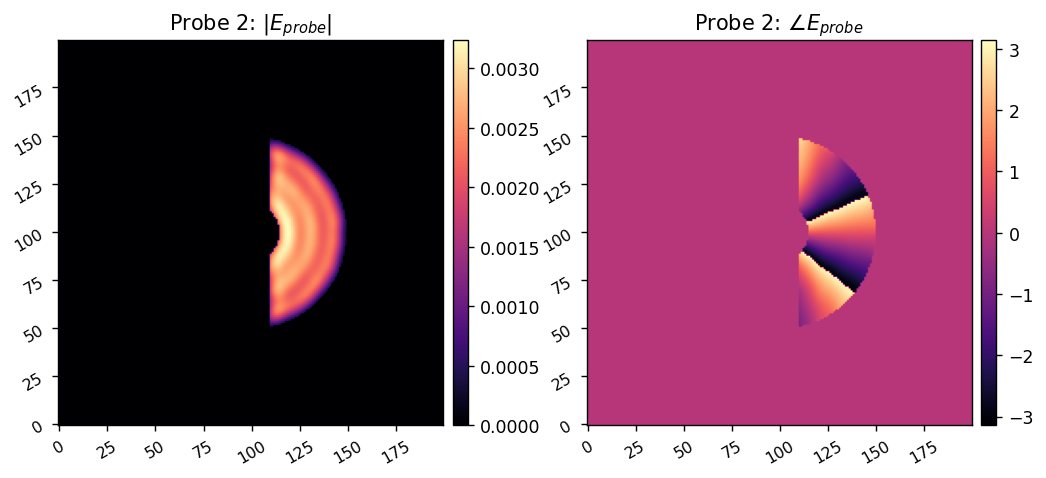

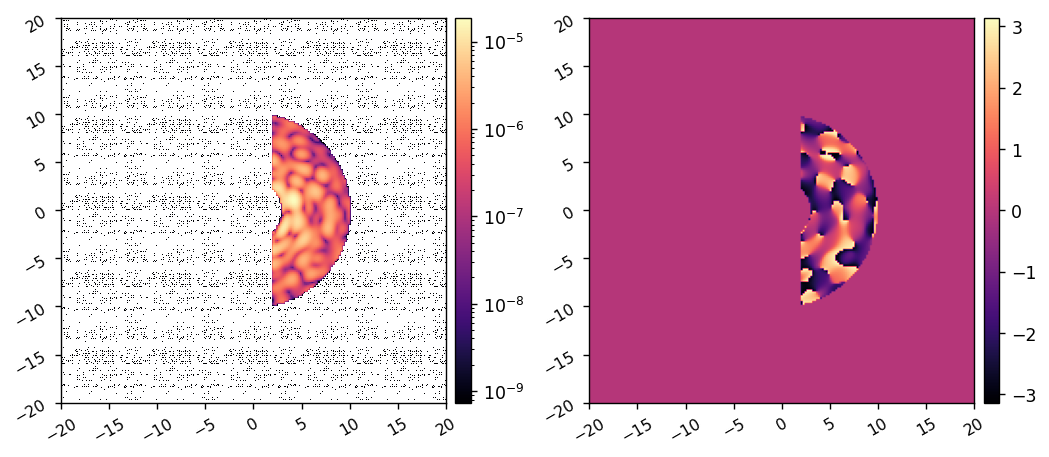

In [34]:
E_pwp = lina.pwp.run_pwp_bp(model, control_mask, probes, 
                            use='J', jacobian=jac, 
        #                     model=None, 
                            plot=True, plot_est=True)

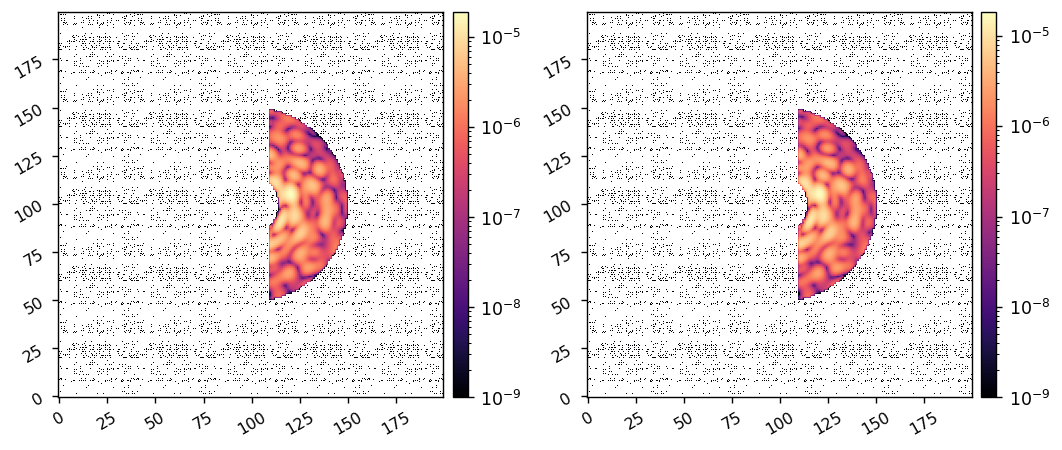

In [23]:

vmin = 1e-9
imshow2(xp.abs(E_pwp)**2, control_mask*ref_im, lognorm=True, 
        vmin1=vmin, vmin2=vmin)

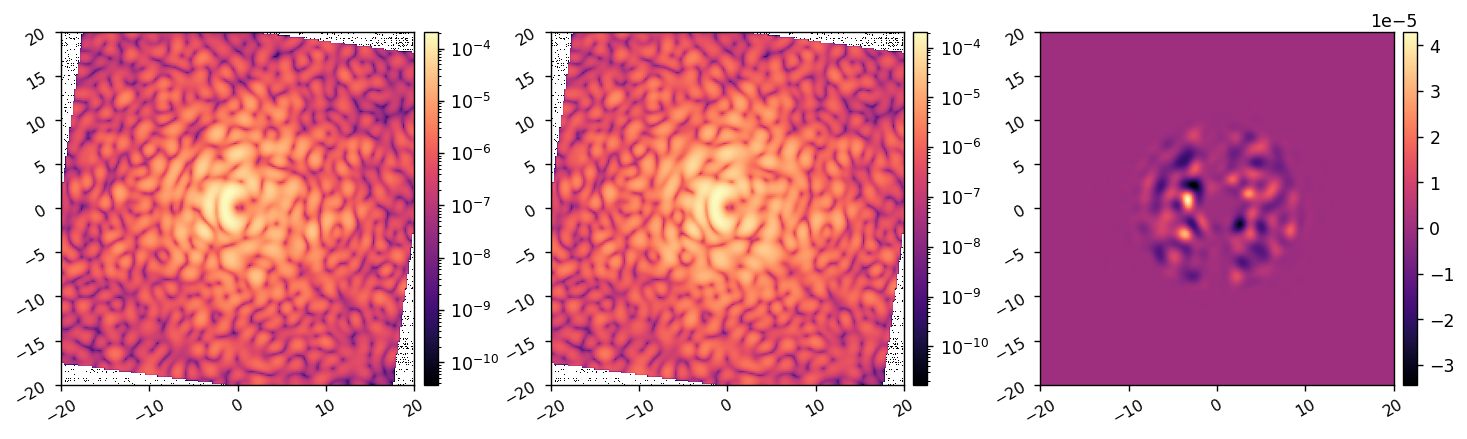

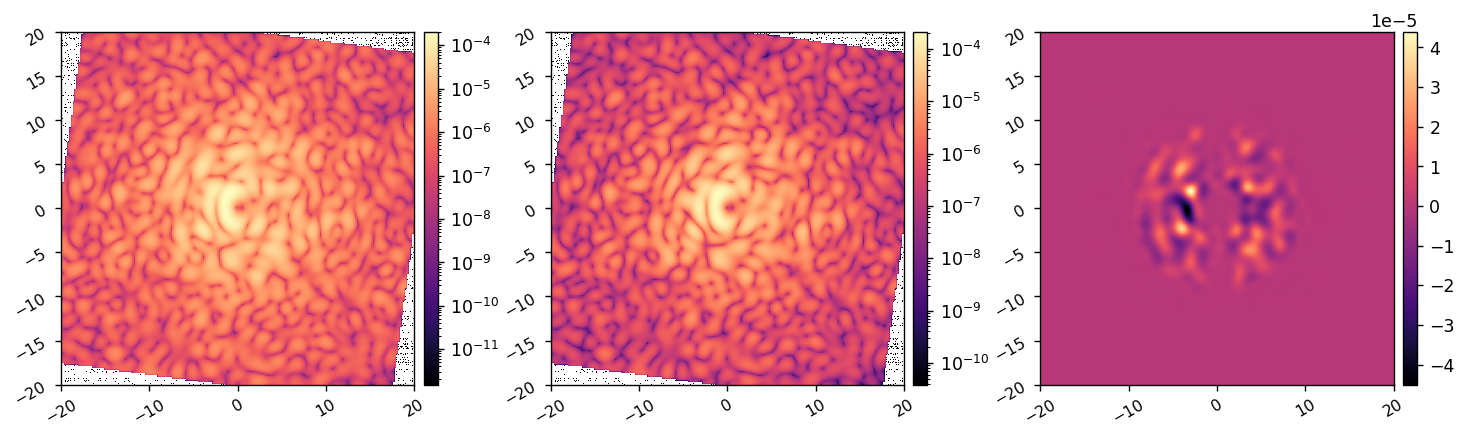

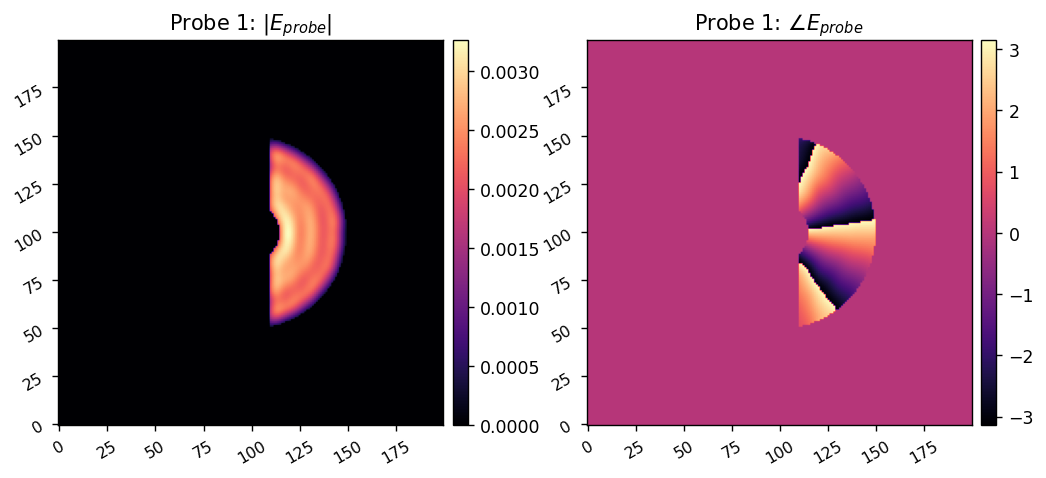

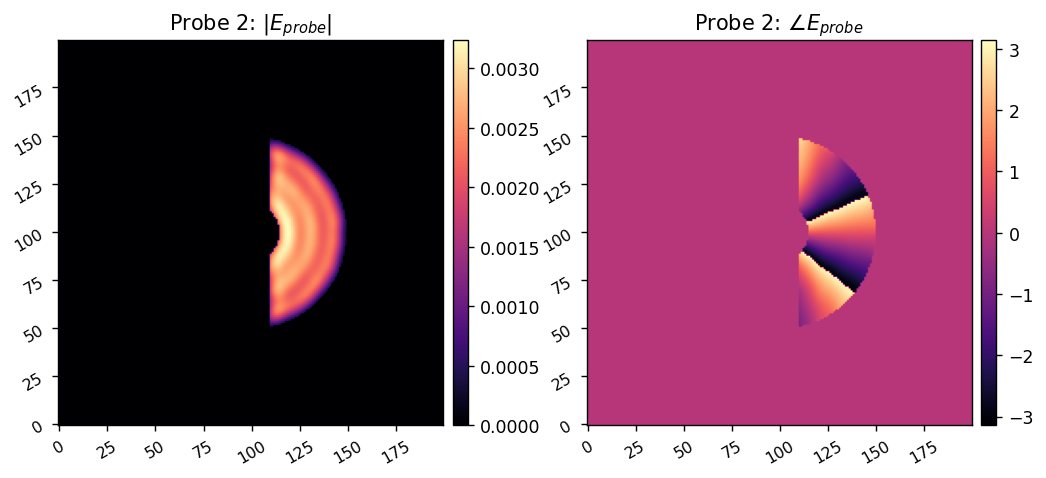

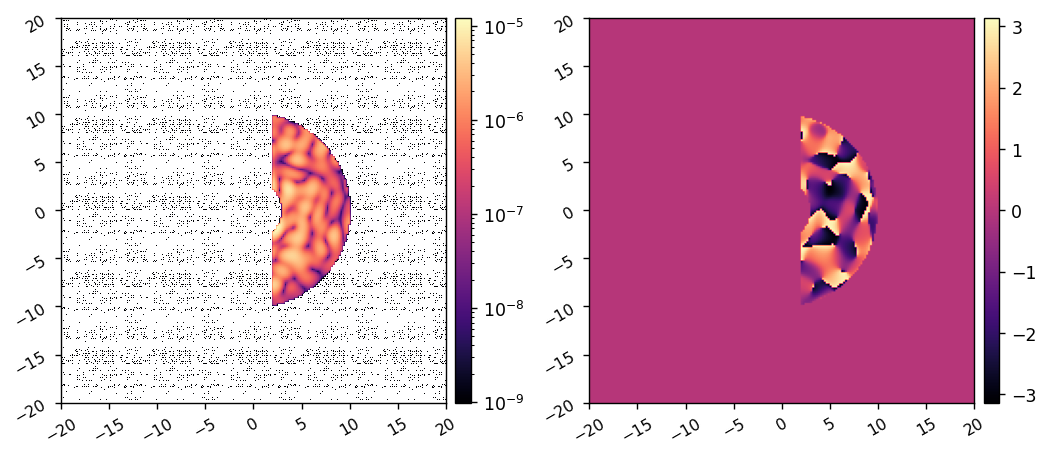

In [35]:
reload(lina.pwp)
E_pwp = lina.pwp.run_pwp_bp(full, control_mask, probes, 
                            use='J', jacobian=jac, 
        #                     model=None, 
                            plot=True, plot_est=True)

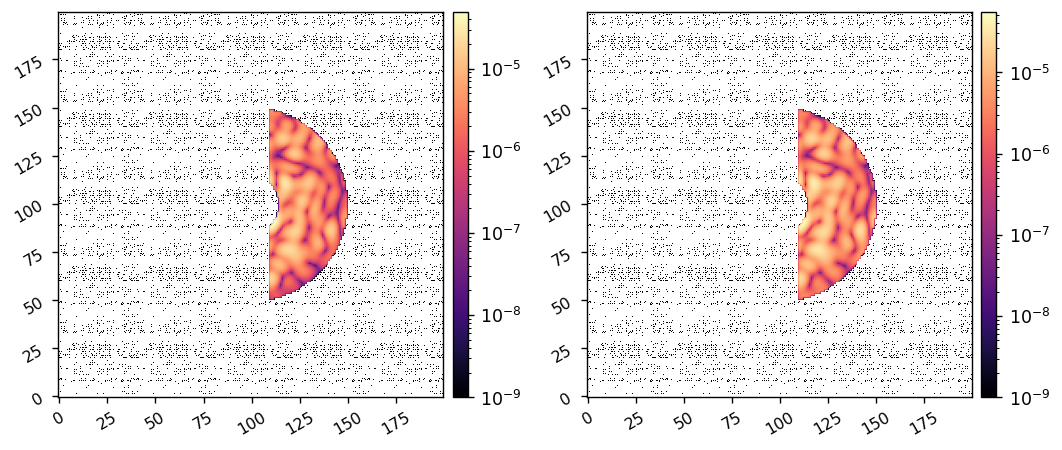

In [39]:
vmin = 1e-9
imshow2(4*xp.abs(E_pwp)**2, control_mask*full_ref_im, lognorm=True, 
        vmin1=vmin, vmin2=vmin)